# Examine Results

In [26]:
from pathlib import Path

import numpy as np
import pandas as pd

from convnwb.io import get_files, load_json

from spiketools.plts.data import plot_hist
from spiketools.plts.utils import make_axes

In [27]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [124]:
# Set which task to run
task = 'THF'

In [125]:
# Set the folder to load results from
base_path = Path('../results/units/')
data_path = base_path / task

In [126]:
# Get the list of files
res_files = get_files(data_path, select='json')

In [127]:
# Check the number of available files
n_files = len(res_files)

## Load Example File

In [128]:
# Load an example file
file = res_files[0]
data = load_json(file, folder=str(data_path))

In [129]:
# Check example file
data

{'session': 'THF_wv001_session_0',
 'uid': 0,
 'wvID': 1,
 'keep': True,
 'cluster': 2229,
 'channel': 'A10',
 'location': 'LAH',
 'n_spikes': 630,
 'firing_rate': 0.5209363104557019,
 'fr_t_val_all': 0.8389638796320972,
 'fr_p_val_all': 0.40512130494096255,
 'fr_t_val_empt': -1.1567316754606853,
 'fr_p_val_empt': 0.26171909017147665,
 'fr_t_val_full': 1.3106454177400326,
 'fr_p_val_full': 0.19851310673361375,
 'place_value': 2.8305826115091426,
 'place_p_val': 0.46,
 'place_z_score': -0.0766708783269144,
 'target_value': 3.6817438133936484,
 'target_p_val': 0.35,
 'target_z_score': 0.35394001116174667,
 'sp_p_val': 0.56,
 'sp_z_score': -0.23936511422130538}

## Collect Results

In [130]:
# Collect all unit results together into a dataframe
all_results = pd.DataFrame()
for file in res_files:
    cur_results = load_json(file, folder=data_path)
    all_results = all_results.append(cur_results, ignore_index=True)

In [131]:
# Clean up some datatypes - cast integers
set_ints = ['uid', 'wvID', 'keep', 'cluster', 'n_spikes']
all_results[set_ints] = all_results[set_ints].astype('int')

In [132]:
# Check the columns
all_results.columns

Index(['session', 'uid', 'wvID', 'keep', 'cluster', 'channel', 'location',
       'n_spikes', 'firing_rate', 'fr_t_val_all', 'fr_p_val_all',
       'fr_t_val_empt', 'fr_p_val_empt', 'fr_t_val_full', 'fr_p_val_full',
       'place_value', 'place_p_val', 'place_z_score', 'target_value',
       'target_p_val', 'target_z_score', 'sp_p_val', 'sp_z_score'],
      dtype='object')

In [133]:
# Check the head of the results
all_results.head()

,session,uid,wvID,keep,cluster,channel,location,n_spikes,firing_rate,fr_t_val_all,...,fr_t_val_full,fr_p_val_full,place_value,place_p_val,place_z_score,target_value,target_p_val,target_z_score,sp_p_val,sp_z_score
0,THF_wv001_session_0,0,1,1,2229,A10,LAH,630,0.520936,0.838964,...,1.310645,0.198513,2.830583,0.460,-0.076671,3.681744,0.350,0.353940,0.560,-0.239365
1,THF_wv001_session_0,1,2,1,2360,A10,LAH,454,0.371356,0.747516,...,2.223143,0.032760,0.823905,0.460,-0.099138,2.939554,0.790,-0.783387,0.374,0.334731
2,THF_wv001_session_0,2,3,1,2421,A10,LAH,580,0.468688,0.659236,...,0.680864,0.500437,0.718185,0.490,-0.238432,2.197244,0.774,-0.781913,0.456,0.055521
3,THF_wv001_session_0,3,4,1,2556,A10,LAH,2164,1.734822,-0.051453,...,-0.739510,0.464529,1.384430,0.136,1.097652,2.738234,0.790,-0.797969,0.456,0.045387
4,THF_wv001_session_0,4,5,1,774,A15,LAH,342,0.276226,-0.850696,...,-0.320374,0.750590,1.140394,0.364,-0.085948,2.538141,0.240,0.654623,0.582,-0.268768


### Location Checks

In [134]:
# Check the set of sampled locations
set(all_results['location'])

{'LA', 'LAH', 'LPH', 'RA', 'RAH', 'RPH'}

<AxesSubplot:>

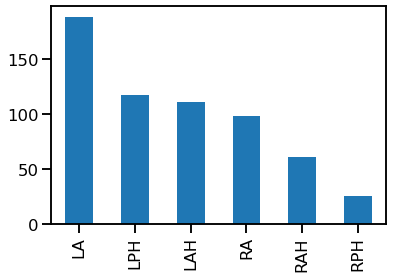

In [135]:
# Plot the counts per location
all_results['location'].value_counts().plot(kind='bar')

### Firing Rate Checks

In [136]:
# Note: is an inf value for firing rate...

In [137]:
# Plot the distribution of firing rates
#plot_hist(all_results['firing_rate'].values)

In [138]:
# Add a marker for firing rate threshold in our task
all_results['frhisteep_th'] = (all_results['firing_rate'] < 0.5).values

### Binary labels

In [139]:
# Set significance level
ALPHA_LEVEL = 0.05

In [140]:
# Add binary labels for statistical tests
all_results['is_chest_cell'] = all_results['fr_p_val_all'] < ALPHA_LEVEL
all_results['is_full_cell'] = all_results['fr_p_val_full'] < ALPHA_LEVEL
all_results['is_empty_cell'] = all_results['fr_p_val_empt'] < ALPHA_LEVEL
all_results['is_place_cell'] = all_results['place_p_val'] < ALPHA_LEVEL
all_results['is_target_cell'] = all_results['target_p_val'] < ALPHA_LEVEL
all_results['is_sp_cell'] = all_results['sp_p_val'] < ALPHA_LEVEL
#all_results['is_head_direction_cell'] = all_results['hd_p_val'] < ALPHA_LEVEL

### Check numbers

In [141]:
# Check the total number of cells
print('Total number of cells: {}'.format(n_files))

Total number of cells: 602


## Check Results

In [142]:
n_cells = len(all_results)

In [143]:
n_chest_cells = sum(all_results['is_chest_cell'])
n_full_cells = sum(all_results['is_full_cell'])
n_empty_cells = sum(all_results['is_empty_cell'])
n_place_cells = sum(all_results['is_place_cell'])
n_target_cells = sum(all_results['is_target_cell'])
n_sp_cells = sum(all_results['is_sp_cell'])

In [144]:
print('{} - total cells: {}\n'.format(task, n_cells))
print('# chest cells: \t\t{:2d} ({:1.2f})'.format(n_chest_cells, n_chest_cells / n_cells))
print('# full cells:  \t\t{:2d} ({:1.2f})'.format(n_full_cells, n_full_cells / n_cells))
print('# empty cells: \t\t{:2d} ({:1.2f})'.format(n_empty_cells, n_empty_cells / n_cells))
print('# place cells: \t\t{:2d} ({:1.2f})'.format(n_place_cells, n_place_cells / n_cells))
print('# target cells:\t\t{:2d} ({:1.2f})'.format(n_target_cells, n_target_cells / n_cells))
print('# sp cells:\t\t{:2d} ({:1.2f})'.format(n_sp_cells, n_sp_cells / n_cells))

THF - total cells: 602

# chest cells: 		81 (0.13)
# full cells:  		108 (0.18)
# empty cells: 		40 (0.07)
# place cells: 		 9 (0.01)
# target cells:		 4 (0.01)
# sp cells:		 1 (0.00)


## Distributions

In [145]:
# Plot settings
bins = 25

### Chest Measures

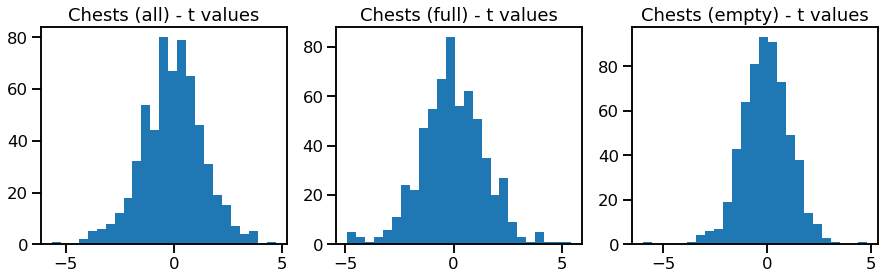

In [146]:
# Plot t-values of the chest measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.fr_t_val_all.values, title='Chests (all) - t values', bins=bins, ax=axes[0])
plot_hist(all_results.fr_t_val_full.values, title='Chests (full) - t values', bins=bins, ax=axes[1])
plot_hist(all_results.fr_t_val_empt.values, title='Chests (empty) - t values', bins=bins, ax=axes[2])

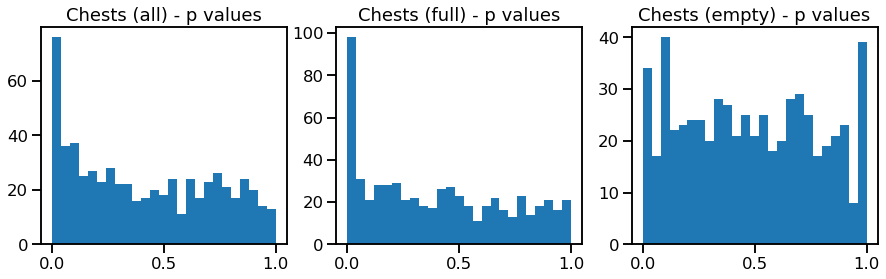

In [147]:
# Plot p-values of the chest measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.fr_p_val_all.values, title='Chests (all) - p values', bins=bins, ax=axes[0])
plot_hist(all_results.fr_p_val_full.values, title='Chests (full) - p values', bins=bins, ax=axes[1])
plot_hist(all_results.fr_p_val_empt.values, title='Chests (empty) - p values', bins=bins, ax=axes[2])

### Position & Sequence Measures

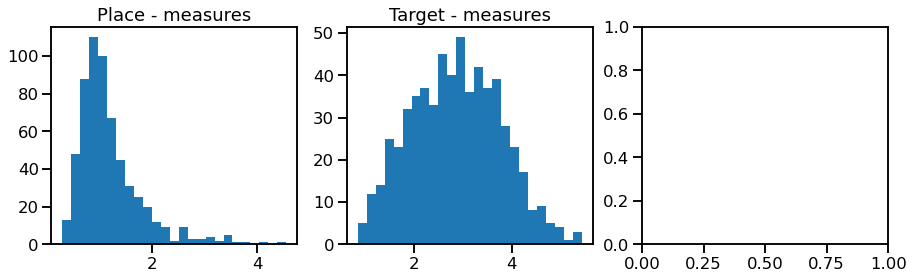

In [148]:
# Plot measure values of the position & sequence measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.place_value.values, title='Place - measures', bins=bins, ax=axes[0])
plot_hist(all_results.target_value.values, title='Target - measures', bins=bins, ax=axes[1])
#plot_hist(all_results.sp_value.values, title='Serial Position - measures', bins=bins, ax=axes[2])

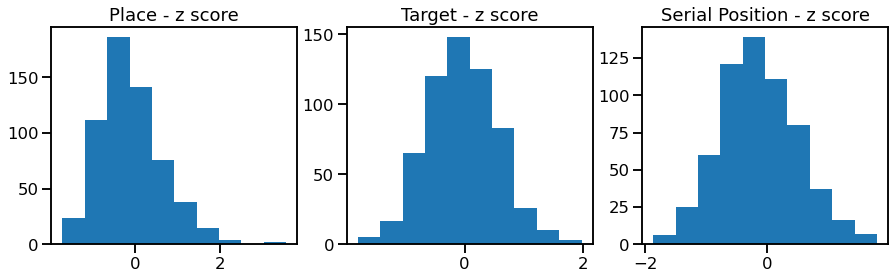

In [149]:
# Plot surrogate z-scores of the position & sequence measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.place_z_score.values, title='Place - z score', ax=axes[0])
plot_hist(all_results.target_z_score.values, title='Target - z score', ax=axes[1])
plot_hist(all_results.sp_z_score.values, title='Serial Position - z score', ax=axes[2])

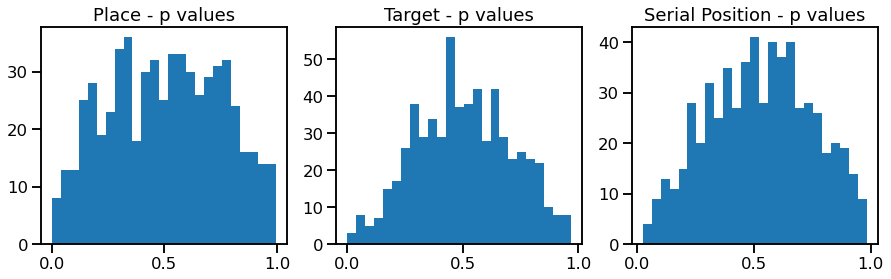

In [150]:
# Plot p values of the position & sequence measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.place_p_val.values, title='Place - p values', bins=bins, ax=axes[0])
plot_hist(all_results.target_p_val.values, title='Target - p values', bins=bins, ax=axes[1])
plot_hist(all_results.sp_p_val.values, title='Serial Position - p values', bins=bins, ax=axes[2])

## Save out results

In [22]:
# Save out of CSV
all_results.to_csv(task + '_all_results.csv')